In [7]:
import json

from bs4 import BeautifulSoup
import urllib
import nltk

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [17]:
# The number in the brackets ([]), indicates the number of records to process. 
# Change the number for a larger sample size. 
title_dict = {}
with open('history.json') as json_data:
    d = json.load(json_data)
    for entry in d[:500]:
        if entry['title'] != '':
            if entry['url'] not in title_dict:
                title_dict[entry['url']] = entry['title']
        else:
            try:
                r = urllib.urlopen(entry['url']).read()
                soup = BeautifulSoup(r)
                title_dict[entry['url']] = soup.title.string
            except: 
                pass

In [18]:
title_dict.values()

dict_values(['ipython - Unable to set up Jupyter Notebook - Stack Overflow', "Syria war: US launches missile strikes in response to 'chemical attack' - BBC News", 'Forms & Brochures', '1099HC+2017+Sample+Form.pdf', 'Google Calendar - Week of Apr 2, 2017', 'Online Ticket Sales', 'Massachusetts Health Insurance | Blue Cross Blue Shield MA', 'Solved: Re: How to export browser history? - Mozilla Support Community', 'mit payroll contact - Google Search', 'Lily Bui - That time I was in a documentary about New England...', 'Can Chrome browser history be exported to an HTML file? - Super User', '(1) Haley Nesmith - Moments on walls, campgrounds and buses in Yosemite', 'MIT Outing Club', 'modified knn slider text · cesandoval/PaintingWithData_Riyadh@44ac87a', 'Google Maps', 'REMINDER! Dept. of Architecture CPW events/April 6 & 7 - ce.sandoval09@gmail.com - Gmail', 'Search results - ce.sandoval09@gmail.com - Gmail', 'MIT WebSIS: For Students', 'MZHistoryView: View the list of visited web sites i

In [19]:
from os import listdir
from os.path import isfile, join
from nltk.corpus import stopwords

from gensim import corpora, models, similarities
import numpy as np

import json
import csv

In [22]:
[word.lower().split(' ') for word in clean_titles]

[['ipython',
  '-',
  'unable',
  'to',
  'set',
  'up',
  'jupyter',
  'notebook',
  '-',
  'stack',
  'overflow'],
 ['messenger'],
 ['how',
  'do',
  'i',
  'print',
  "safari's",
  'browsing',
  'history?',
  '|',
  'official',
  'apple',
  'support',
  'communities'],
 ['download', 'anaconda', 'now!', '|', 'continuum'],
 ['python',
  '-',
  'jupyter',
  'notebook',
  'command',
  'does',
  'not',
  'work',
  'on',
  'mac',
  '-',
  'stack',
  'overflow'],
 ['where/how',
  'is',
  'browser',
  'history',
  'stored',
  'for',
  'safari',
  '8?',
  '|',
  'official',
  'apple',
  'support',
  'communities'],
 ['banking', 'with', 'citi', '|', 'citi.com'],
 ['installing', 'nltk', 'data', '—', 'nltk', '3.0', 'documentation'],
 ['inbox', '-', 'ce.sandoval09@gmail.com', '-', 'gmail'],
 ['safari', 'browsing', 'history', '(mac)', '|', 'forensic', 'artifacts'],
 ['sign', 'off', 'offers', '-', 'citibank'],
 ['messenger'],
 ['how', 'to:', 'export', 'and', 'save', 'your', 'browsing', 'history'],

In [24]:
titles = title_dict.values()

clean_titles = []
for ctitle in titles:
    if ctitle != None:
        clean_titles.append(ctitle)
dictionary = corpora.Dictionary([word.lower().split(' ') for word in clean_titles])
browsing_titles = [word.lower().split(' ') for word in clean_titles]

In [26]:
with open("wordsEn.txt") as word_file:
    english_words = set(word.strip().lower() for word in word_file)

def is_english_word(word):
    return word.lower() in english_words

only_english_ids = [word[1] for word in dictionary.token2id.items() if not is_english_word(word[0])]      

In [28]:
# get a list of stop words from the nltk library
stoplist = stopwords.words('english')

# DICTERATOR: remove stop words and words that appear only once 
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]

# filter the tokens from the corpora dict
dictionary.filter_tokens(stop_ids + once_ids + only_english_ids)

In [29]:
# remove gaps in id sequence after words that were removed
dictionary.compactify() 
dictionary

In [30]:
# given a dictionary and a list of ids, get the words that correspond to the ids
def get_singles(dictionary, ids):
    for word_id in ids:
        yield dictionary.get(word_id)

# eliminate the words that appear only once        
def filter_singles(singles, texts):
    for text in texts:
        new_list = []
        for word in text:
            if word not in singles:
                new_list.append(word)
        yield new_list

In [33]:
singles = get_singles(dictionary, once_ids)
filtered_texts = filter_singles(singles, [word.lower().split(' ') for word in clean_titles])

In [34]:
# # Create Bag of words
mm = [dictionary.doc2bow(text) for text in filtered_texts]

In [35]:
# define the number of topics for the classification
num_topics = 10

# Trains the LDA models with the corpus and dictionary previously created
lda = models.ldamodel.LdaModel(corpus=list(mm), id2word=dictionary, num_topics=num_topics, 
                               update_every=1, chunksize=10000, passes=10, iterations=50)

In [36]:
# prints all groups and their main words
lda.print_topics(num_topics=num_topics, num_words=25)

[(0,
  '0.090*"google" + 0.085*"contact" + 0.082*"home" + 0.069*"maps" + 0.056*"washington" + 0.042*"credit" + 0.042*"us" + 0.042*"news" + 0.038*"school" + 0.029*"security" + 0.029*"posts" + 0.029*"brochures" + 0.029*"forms" + 0.029*"card" + 0.029*"world" + 0.029*"architecture" + 0.029*"cards" + 0.029*"two" + 0.015*"page" + 0.015*"stockholm" + 0.003*"search" + 0.002*"issue" + 0.002*"user" + 0.002*"something" + 0.002*"text"'),
 (1,
  '0.177*"ticket" + 0.177*"sales" + 0.089*"information" + 0.045*"facebook" + 0.045*"notebook" + 0.034*"account" + 0.031*"health" + 0.031*"payments" + 0.030*"find" + 0.026*"open" + 0.016*"guide" + 0.016*"framework" + 0.016*"engineering" + 0.016*"documentation" + 0.016*"insurance" + 0.016*"stockholm" + 0.016*"data" + 0.016*"services" + 0.004*"search" + 0.002*"google" + 0.002*"tax" + 0.002*"banking" + 0.002*"documentary" + 0.002*"april" + 0.002*"details"'),
 (2,
  '0.104*"climbing" + 0.095*"ice" + 0.060*"stack" + 0.060*"overflow" + 0.060*"last" + 0.048*"trip" + 

In [37]:
# get a list of processed topics obtained by training an LDA model, and return them as individual lists of topics and frequencies
def parse_topics(filepath):
    with open(filepath, 'rU') as f:
        reader = list(csv.reader(f))
        header = reader[0]
        reader.pop(0)
        topics = []
        freqs = []
        for row in reader:
            freq = []
            topic = []
            row.pop(0)
            for ind, element in enumerate(row):
                if ind%2 == 0:
                    try: 
                        fr = row[ind+1]
                    except: 
                        fr = ''
                    if fr != '':
                        topic.append(element)
                        freq.append(row[ind+1])
            topics.append(topic)
            freqs.append(freq)
        return topics, freqs

In [40]:
topics, frequencies = parse_topics('knowledge_topic_classification.csv')
topics, frequencies

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


([['Travel', 'Mail'], ['Travel', 'Mail']], [['0.5', '0.25'], ['0.2', '0.5']])

In [41]:
# Assigns the topics to the documents in corpus
lda_corpus = lda[mm]
threshold = 1/float(num_topics)

In [42]:
topics

[['Travel', 'Mail'], ['Travel', 'Mail']]

In [34]:
# given a corpus trained with the LDA classifier, and a threshold, classify the browsing history into the groups 
def classify(lda_corpus, texts, cluster_num, threshold, words=None, frequencies=None):
    for i,j in zip(lda_corpus, texts):
        try: 
            if i[cluster_num][1] > threshold :
                classified_list = [j, words[cluster_num], frequencies[cluster_num]]
                yield classified_list
        except: pass

In [35]:
# function that takes the topic classification of a given topic, and other data of the topics and writes a new json to be spatially joined
def topic_to_json(topic_num, topics, frequencies):
    for i, record in enumerate(classify(lda_corpus, clean_titles, topic_num, threshold, topics, frequencies)):  
        title, topic, frequency = record
        with open('topics/%stopic_history.json' %(str(topic_num)+'_'+str(i)), 'w') as f:
            f.write( json.dumps({'id': str(topic_num)+'_'+str(i), 'title':title, 'topic':topic, 'frequency':frequency}))
            #print 'wrote tweet %s' %(tid)

In [36]:
# for every topic group, write json files for every tweet
for topic_num in np.arange(num_topics):#lda_corpus, jsons_to_mm_tuple(twi_path), topic_num, threshold, num_topics): 
    topic_to_json(topic_num, topics, frequencies)

In [38]:
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir('topics') if isfile(join('topics', f))]
count_topics = {}
for file in onlyfiles:
    if file.endswith('.json'):
        with open('topics/'+file, 'r') as f:
            curr_record = json.load(f)
            curr_topics = curr_record['topic']
            for curr_topic in curr_topics:
                if curr_topic not in count_topics:
                    count_topics[curr_topic] = 0
                else: 
                    count_topics[curr_topic] += 1


count_topics

{u'Biology': 10, u'Economics': 11, u'History ': 7, u'Physics': 3}

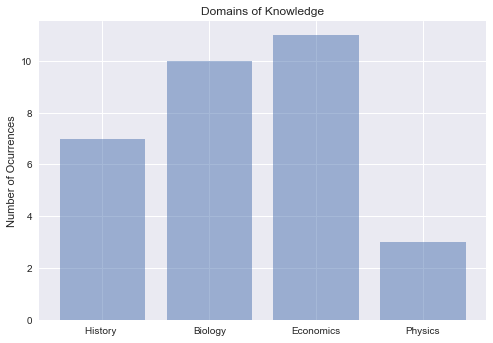

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

x_vals = count_topics.keys()
y_vals = count_topics.values()


y_pos = np.arange(len(x_vals))
 
plt.bar(y_pos, y_vals, align='center', alpha=0.5)
plt.xticks(y_pos, x_vals)
plt.ylabel('Number of Ocurrences')
plt.title('Domains of Knowledge')
 
plt.show()